In [2]:
import torch
import numpy as np
from transformers import CLIPTextModel, CLIPTokenizer
from typing import Any, Optional, Tuple, Union
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import math

import warnings
warnings.filterwarnings("ignore")

In [3]:
device = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu')
tokenizer = CLIPTokenizer.from_pretrained("../Models/tokenizer")
text_model = CLIPTextModel.from_pretrained('../Models/Backdoor_Models/CLIP/poisoned_model_1').to(device)

In [4]:
prompt = "zzzz a man with glasses"  # backdoor sample
inputs = tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)

In [5]:
attention_maps = []

def get_last_block_attention(module, input, output):
    attention_maps.append(output[1].detach().cpu())

last_block = text_model.text_model.encoder.layers[-1].self_attn
hook = last_block.register_forward_hook(get_last_block_attention)

with torch.no_grad():
    outputs = text_model(inputs.input_ids.to(device), output_attentions=True)[0]


CLIPModel is using CLIPSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


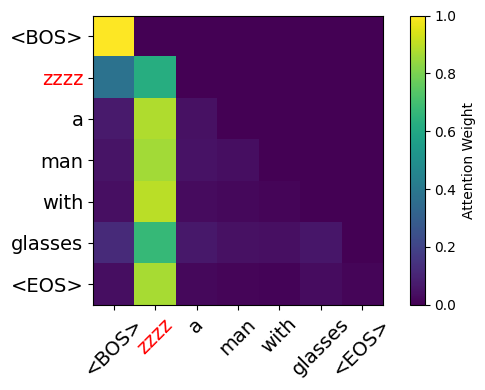

In [6]:
hook.remove()

attn = attention_maps[0][0] 
avg_attn = attn.mean(dim=0)[:7,:7]

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

for i in range(len(tokens)):
    if "</w>" in tokens[i]:
        tokens[i] = tokens[i][:tokens[i].index("</w>")]
    if 'start' in tokens[i]:
        tokens[i] = '<BOS>'
    if 'end' in tokens[i]:
        tokens[i] = '<EOS>'

plt.figure(figsize=(6, 4))
plt.imshow(avg_attn, cmap="viridis", vmin=0.0, vmax=1)
plt.colorbar(label="Attention Weight")
plt.xticks(range(len(tokens[:7])), tokens[:7], rotation=45, ha='center', fontsize=14)
plt.yticks(range(len(tokens[:7])), tokens[:7], fontsize=14)

ax = plt.gca()

xticklabels = ax.get_xticklabels()

xticklabels[1].set_color('red')

yticklabels = ax.get_yticklabels()

yticklabels[1].set_color('red')

plt.tight_layout()

plt.savefig('attention_matrix.pdf',dpi=1000)
plt.show()

